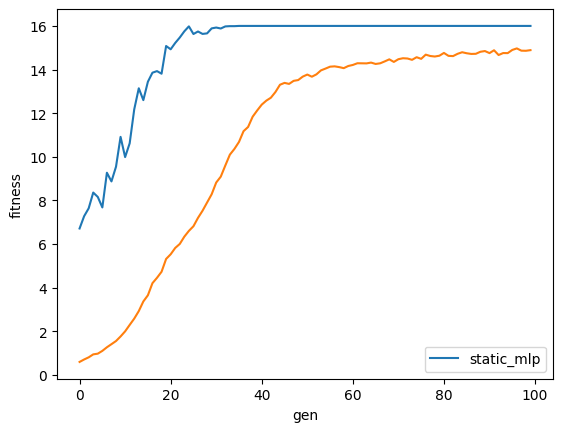

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import numpy as np
import os

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

trials_start = 0
trials_finish = 10
trials = trials_finish-trials_start
data_points = 100
stat_run_base_path = "/home/magraz/vmas_rovers/src/experiments/results/"
experiment_type = "sanity"
configurations = ["static_mlp"]
stat_run_paths = [os.path.join(stat_run_base_path, "_".join((experiment_type, config))) for config in configurations]

dd_list = []

for i in range(len(stat_run_paths)):

    for trial in range(trials_start,trials_finish):

        dd = defaultdict(list)

        with open(
            os.path.join(stat_run_paths[i], "_".join(("trial", str(trial), configurations[i])), "fitness.csv"), "r"
        ) as csvfile:
            for line in csv.DictReader(csvfile):
                for key, value in line.items():
                    if key != "" and value != "" and value != None and not isinstance(value, list):
                        dd[key].append(float(value))

        dd_list.append(dd)

best_team_fitness_avg_vals = []
best_team_fitness_std_vals = []

avg_team_fitness_avg_vals = []
avg_team_fitness_std_vals = []

for i in range(len(configurations)):

    best_team_fitness = []
    avg_team_fitness = []

    for dd in dd_list[i * trials : (i + 1) * trials]:
        best_team_fitness.append(np.array(dd["best_team_fitness"][:data_points]))
        avg_team_fitness.append(np.array(dd["avg_team_fitness"][:data_points]))

    best_team_fitness = np.array(best_team_fitness)
    avg_team_fitness = np.array(avg_team_fitness)

    best_team_fitness_avg_vals.append(np.mean(best_team_fitness, axis=0))
    best_team_fitness_std_vals.append(np.std(best_team_fitness, axis=0))

    avg_team_fitness_avg_vals.append(np.mean(avg_team_fitness, axis=0))
    avg_team_fitness_std_vals.append(np.std(avg_team_fitness, axis=0))


fig = plt.figure()
ax = fig.add_subplot(111)

window_size = 1

for best_fitness_avg, avg_fitness_avg in zip(best_team_fitness_avg_vals,avg_team_fitness_avg_vals):
    # window_avg = np.lib.stride_tricks.sliding_window_view(avg, window_size)
    # window_std = np.lib.stride_tricks.sliding_window_view(std, window_size)

    # moving_avg = np.mean(window_avg, axis=-1)
    # moving_std = np.mean(window_std, axis=-1)

    best_fitness_moving_avg = moving_average(best_fitness_avg, window_size)
    avg_fitness_moveing_avg = moving_average(avg_fitness_avg, window_size)
    # moving_std = moving_average(std, window_size)

    # std_plus = moving_avg + moving_std/np.sqrt(trials)
    # std_minus = moving_avg - moving_std/np.sqrt(trials)

    ax.plot(best_fitness_moving_avg)
    ax.plot(avg_fitness_moveing_avg)
    # ax.plot(moving_std)
    # ax.fill_between(np.linspace(0, moving_avg.shape[0], moving_avg.shape[0]), std_plus, std_minus, alpha=0.2)

ax.set_xlabel("gen")
ax.set_ylabel("fitness")

plt.legend(configurations) 

plt.show()
